In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import scipy.stats as stats
import matplotlib.pyplot as plt

from os.path import join
from statsmodels.stats.multitest import multipletests

import warnings
warnings.filterwarnings("ignore")

In [2]:
plt.rcParams['font.sans-serif'] = ['Hiragino Sans GB']
plt.rcParams['axes.unicode_minus'] = False

# Problem 1

问题 1. 请分析附件 train.csv 中的数据，分析并可视化上述 20 个指标中，哪些指标与洪水的发生有着密切的关联？哪些指标与洪水发生的相关性不大？并分析可能的原因，然后针对洪水的提前预防，提出你们合理的建议和措施。

In [3]:
data_root = r'/Users/drew/Documents/MathModeling/MathModeling/APMCM24_cn/data'

train_path = join(data_root, 'train.csv')
test_path = join(data_root, 'test.csv')

train = pd.read_csv(train_path, index_col='id')
test = pd.read_csv(test_path, index_col='id')

initial_features = list(test.columns)[:-1]

train.head()

季风强度  地形排水  河流管理  森林砍伐  城市化  气候变化  大坝质量  淤积  农业实践  侵蚀  ...  排水系统  海岸脆弱性  \
id                                                         ...                
0      5     8     5     8    6     4     4   3     3   4  ...     5      3   
1      6     7     4     4    8     8     3   5     4   6  ...     7      2   
2      6     5     6     7    3     7     1   5     4   5  ...     7      3   
3      3     4     6     5    4     8     4   7     6   8  ...     2      4   
4      5     3     2     6    4     4     3   3     3   3  ...     2      2   

    滑坡  流域  基础设施恶化  人口得分  湿地损失  规划不足  政策因素   洪水概率  
id                                                 
0    3   5       4     7     5     7     3  0.445  
1    0   3       5     3     3     4     3  0.450  
2    7   5       6     8     2     3     3  0.530  
3    7   4       4     6     5     7     5  0.535  
4    6   6       4     1     2     3     5  0.415  

[5 rows x 21 columns]

In [4]:
train.isna().any()

季风强度      False
地形排水      False
河流管理      False
森林砍伐      False
城市化       False
气候变化      False
大坝质量      False
淤积        False
农业实践      False
侵蚀        False
无效防灾      False
排水系统      False
海岸脆弱性     False
滑坡        False
流域        False
基础设施恶化    False
人口得分      False
湿地损失      False
规划不足      False
政策因素      False
洪水概率      False
dtype: bool

In [5]:
test.isna().any()

季风强度      False
地形排水      False
河流管理      False
森林砍伐      False
城市化       False
气候变化      False
大坝质量      False
淤积        False
农业实践      False
侵蚀        False
无效防灾      False
排水系统      False
海岸脆弱性     False
滑坡        False
流域        False
基础设施恶化    False
人口得分      False
湿地损失      False
规划不足      False
政策因素      False
洪水概率       True
dtype: bool

In [6]:
print(initial_features)

['季风强度', '地形排水', '河流管理', '森林砍伐', '城市化', '气候变化', '大坝质量', '淤积', '农业实践', '侵蚀', '无效防灾', '排水系统', '海岸脆弱性', '滑坡', '流域', '基础设施恶化', '人口得分', '湿地损失', '规划不足', '政策因素']


## 洪水发生概率分布情况

由于测试集中的洪水发生概率仍旧是缺失值，因此无法直接计算测试集的洪水概率分布情况，此处仅对训练集进行统计

In [7]:
train.describe().洪水概率

count    1.048575e+06
mean     5.044697e-01
std      5.103092e-02
min      2.850000e-01
25%      4.700000e-01
50%      5.050000e-01
75%      5.400000e-01
max      7.250000e-01
Name: 洪水概率, dtype: float64

对洪水发生概率进行统计，得出其最小值为0.285，最大值为 0.725

因此对其进行可视化时扩展设置信度为0.005，则扩展下界到0.2825，扩展上界到0.7275，构造90个箱体进行概率密度的可视化

In [8]:
np.linspace(0.2825, 0.7275, 90)[:5], (0.7275 - 0.2825)/90

(array([0.2825, 0.2875, 0.2925, 0.2975, 0.3025]), 0.004944444444444445)

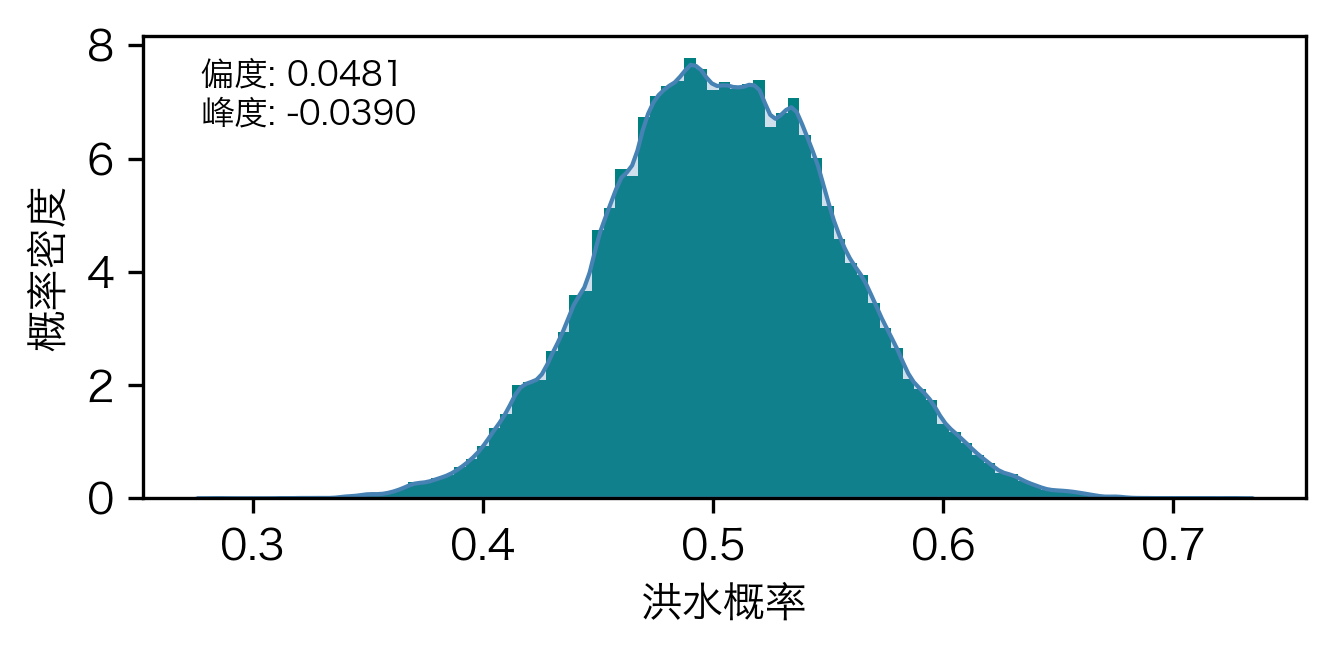

In [9]:
flood_df = train.洪水概率
# 计算偏度和峰度
flood_df_skew = stats.skew(flood_df.dropna())  # 删除 NaN 值并计算偏度
flood_df_kurt = stats.kurtosis(flood_df.dropna())  # 删除 NaN 值并计算峰度
plt.figure(figsize=(5, 2), dpi=300)
plt.hist(
    flood_df, 
    bins=np.linspace(0.2825, 0.7275, 90), 
    density=True,
    color='teal',
)
sns.kdeplot(
    flood_df, 
    color='steelblue', 
    shade=True,
)
# 添加偏度和峰度到图的左上角
plt.text(
    0.05,  # x 位置
    0.95,  # y 位置，可以根据你的图形布局进行调整
    f'偏度: {flood_df_skew:.4f}\n峰度: {flood_df_kurt:.4f}',  # 要显示的文本
    horizontalalignment='left',  # 水平对齐方式
    verticalalignment='top',  # 垂直对齐方式
    transform=plt.gca().transAxes,  # 将位置指定为图形坐标轴的比例
    fontsize=8
)
plt.ylabel('概率密度')
plt.xlabel('洪水概率')
plt.show()

In [10]:
print(f'偏度: {flood_df_skew:.4f}\n峰度: {flood_df_kurt:.4f}')

偏度: 0.0481
峰度: -0.0390


**洪水分布情况**:
   - 偏度（Skewness）: 0.0481，接近0，表明洪水发生概率的分布接近对称，没有明显的右偏或左偏。
   - 峰度（Kurtosis）: -0.0390，表明洪水发生概率的分布比正态分布稍微平坦一些，也就是说，其峰值不是很明显，尾部相对更厚。

## 特征分布情况

对每个特征进行统计，并统计出训练集和测试集中每个特征的分布情况

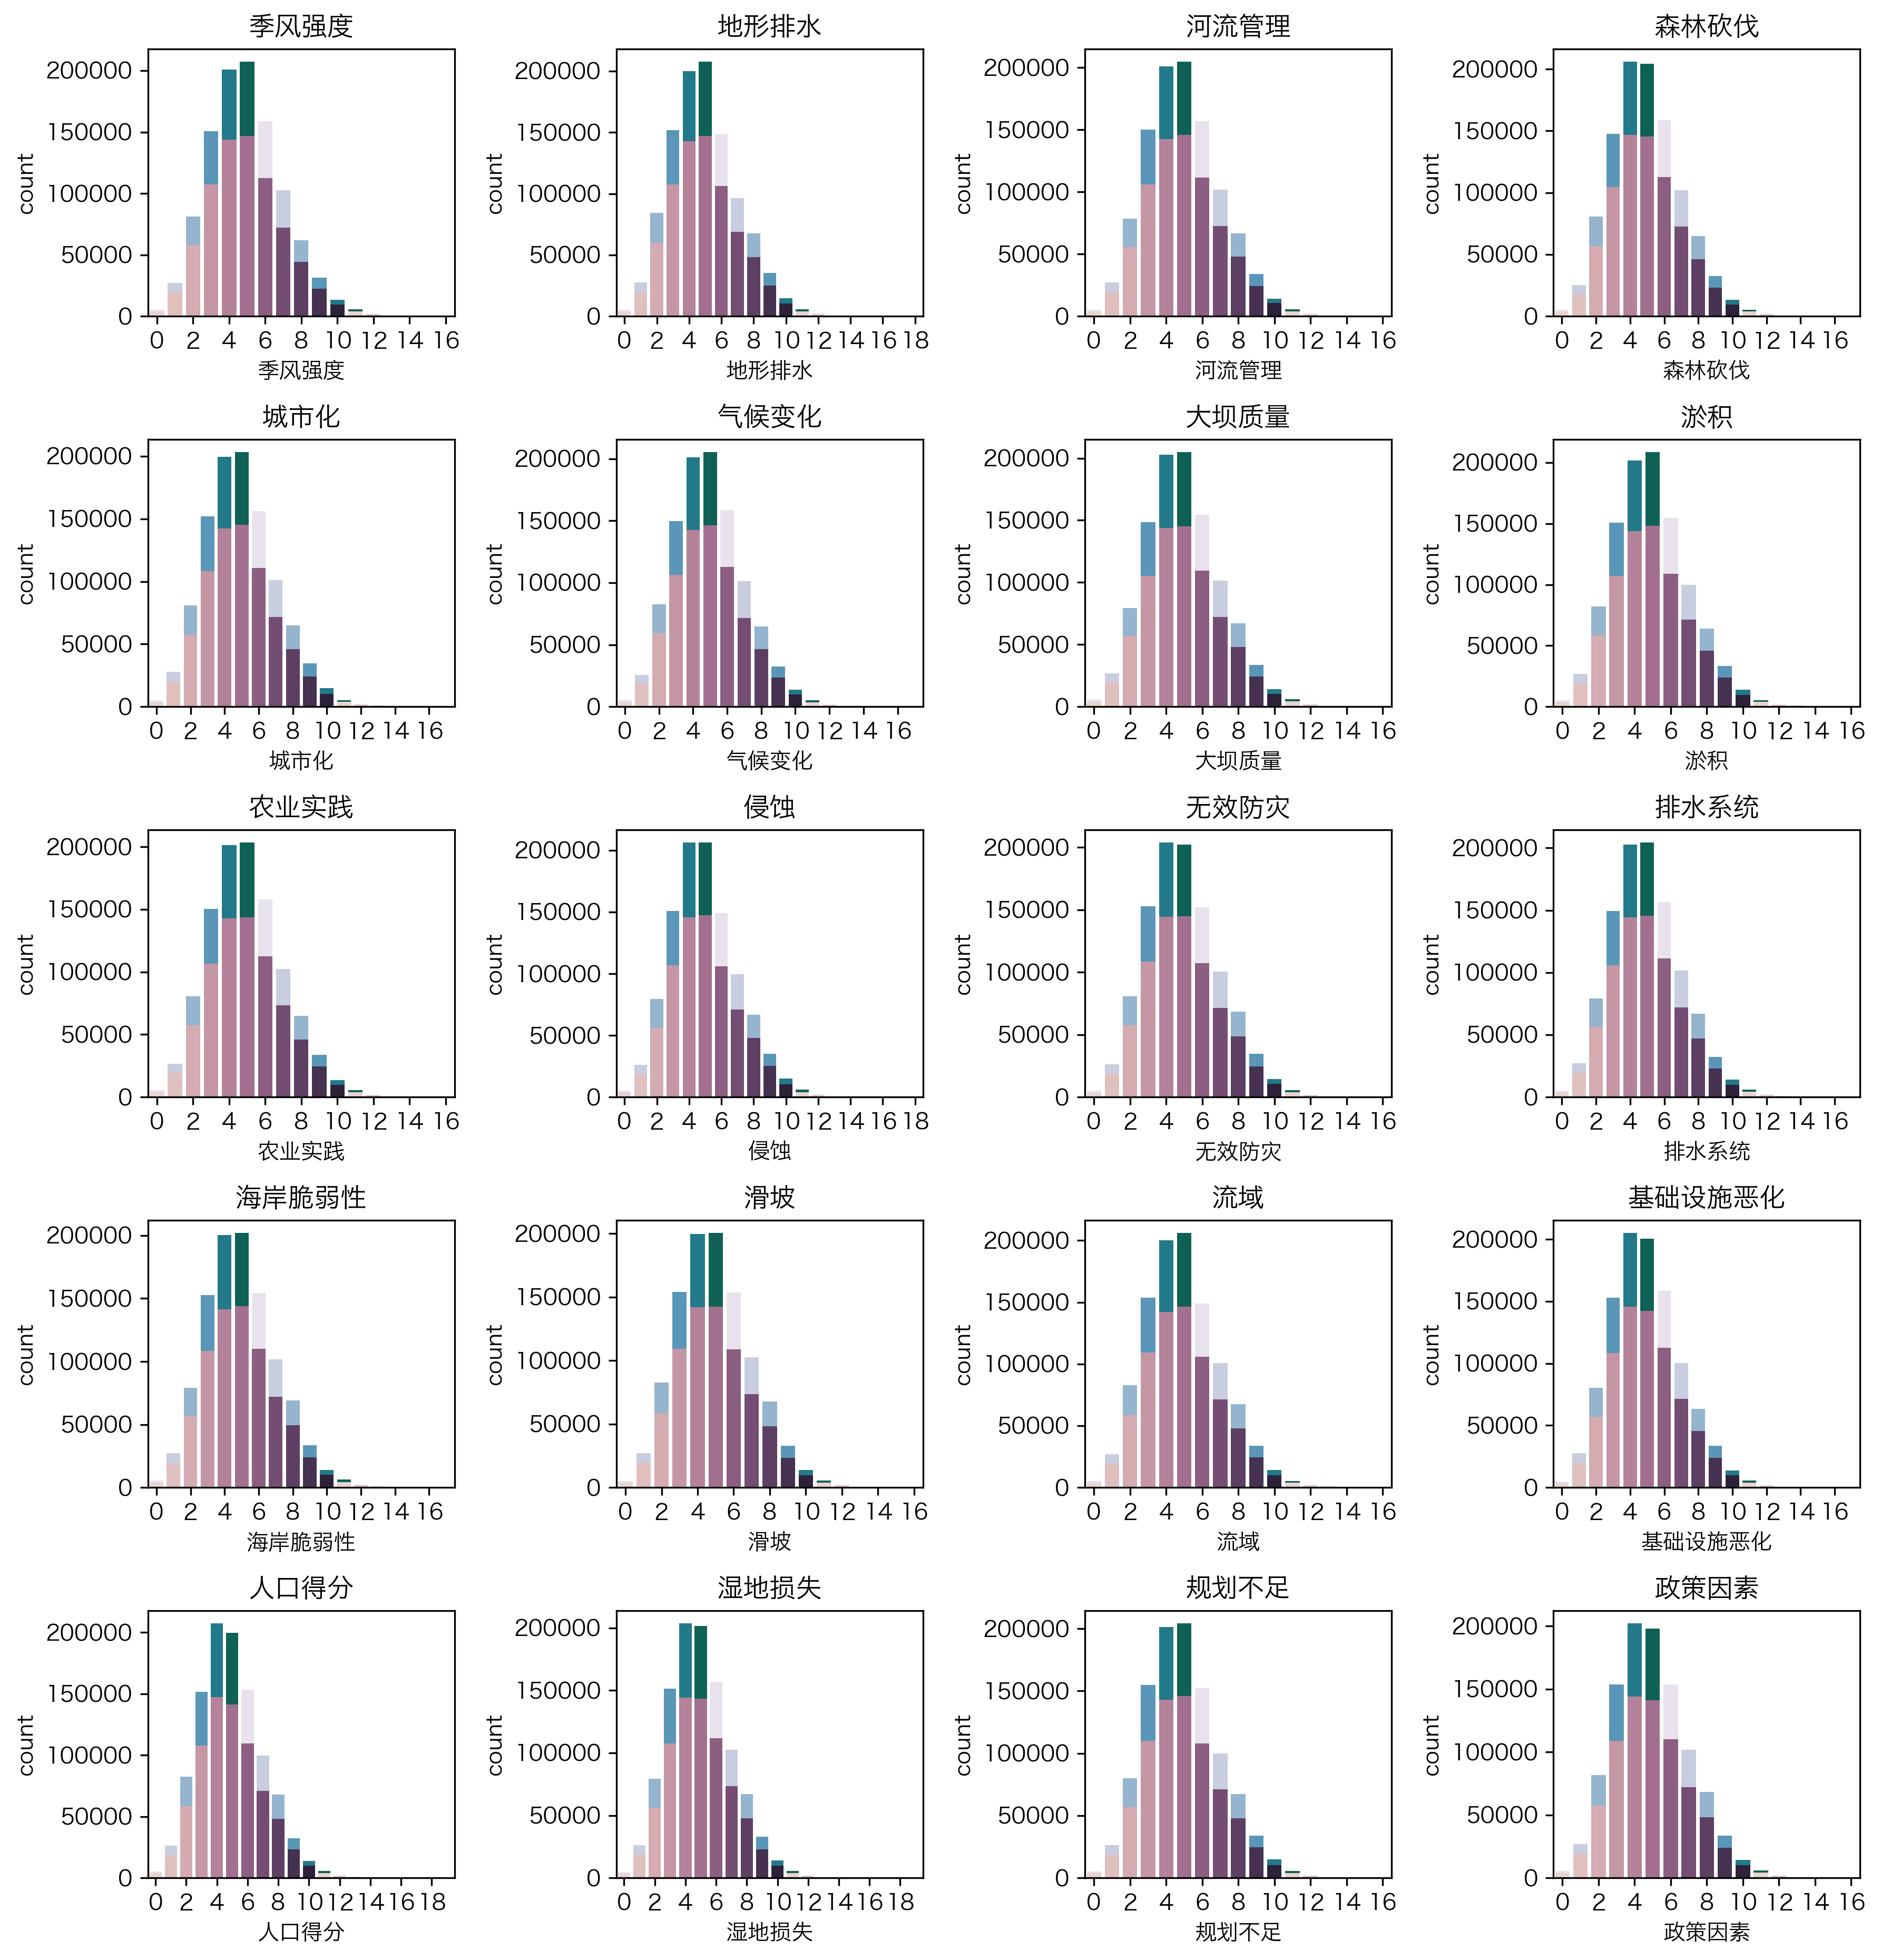

In [11]:
ncol = 4
nrow = int(np.ceil(len(initial_features) / 4))
plt.figure(figsize=(ncol*3, nrow*2.5), dpi=300)
pal_train = sns.color_palette("PuBuGn")
pal_test = sns.cubehelix_palette(11)
for i,col in enumerate(initial_features):
    ax = plt.subplot(nrow, ncol, i+1)
    sns.countplot(train,x=col,ax=ax,palette=pal_train)
    sns.countplot(test,x=col,ax=ax,palette=pal_test)
    ax.set_title(col)
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
plt.tight_layout()

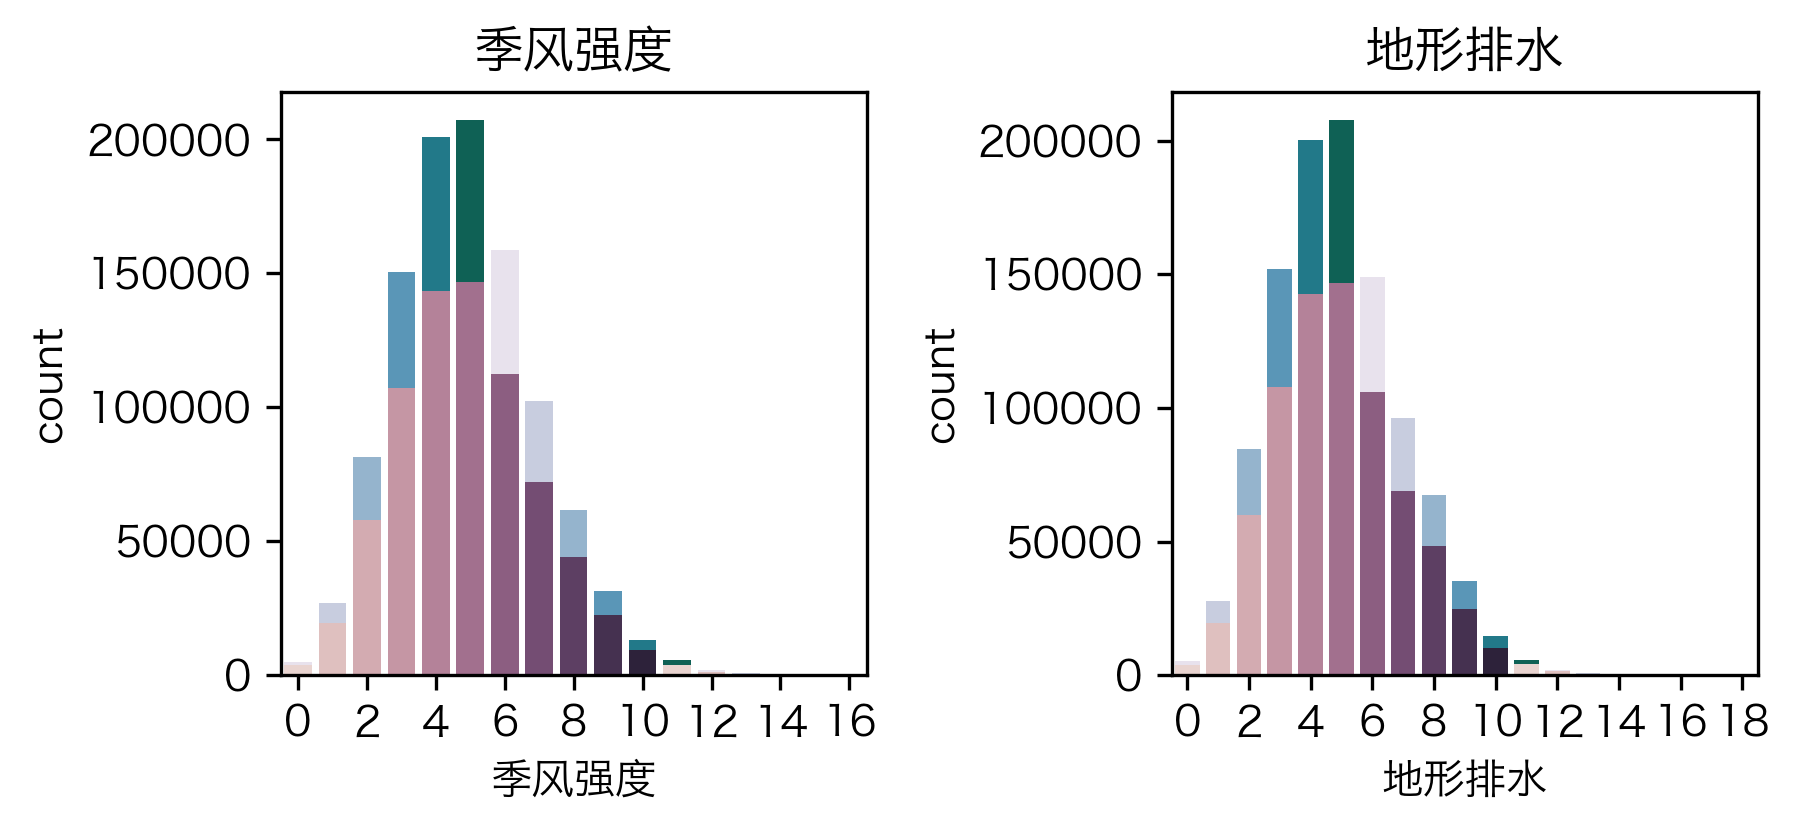

In [13]:
# 假设 initial_features 是一个包含至少两个特征名称的列表
# 假设 train 和 test 是包含这些特征的 DataFrame
from matplotlib import ticker

ncol = 4
nrow = int(np.ceil(len(initial_features) / 4))  # 计算需要的行数

plt.figure(figsize=(ncol*3, nrow*2.5), dpi=300)

# 创建颜色方案
pal_train = sns.color_palette("PuBuGn")
pal_test = sns.cubehelix_palette(11)

# 仅绘制前两个特征
for i, col in enumerate(initial_features[:2]):  # 修改这里以仅迭代前两个特征
    ax = plt.subplot(nrow, ncol, i + 1)  # 子图布局
    sns.countplot(train[train[col].notnull()], x=col, ax=ax, palette=pal_train)  # 绘制训练集的计数图
    sns.countplot(test[test[col].notnull()], x=col, ax=ax, palette=pal_test)  # 绘制测试集的计数图
    ax.set_title(col)  # 设置子图标题
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))  # 设置x轴刻度为整数

plt.tight_layout()  # 调整子图布局以避免重叠
plt.show()  # 显示图形

In [ ]:
stats_results = {'特征': [], '训练集偏度系数': [], '训练集峰度系数': [], 
                 '测试集偏度系数': [], '测试集峰度系数': []}

for col in initial_features:
    train_skew = stats.skew(train[col].dropna())
    train_kurt = stats.kurtosis(train[col].dropna())
    test_skew = stats.skew(test[col].dropna())
    test_kurt = stats.kurtosis(test[col].dropna())
    
    stats_results['特征'].append(col)
    stats_results['训练集偏度系数'].append(train_skew)
    stats_results['训练集峰度系数'].append(train_kurt)
    stats_results['测试集偏度系数'].append(test_skew)
    stats_results['测试集峰度系数'].append(test_kurt)

stats_df = pd.DataFrame(stats_results, index=stats_results['特征'])
stats_df.drop(['特征'], axis=1, inplace=True)
stats_df

训练集偏度系数   训练集峰度系数   测试集偏度系数   测试集峰度系数
季风强度    0.443775  0.339473  0.439720  0.315153
地形排水    0.459312  0.240781  0.460378  0.246420
河流管理    0.426512  0.225037  0.413858  0.182297
森林砍伐    0.434045  0.274500  0.438961  0.294516
城市化     0.441572  0.246507  0.448929  0.276395
气候变化    0.429192  0.240898  0.431095  0.246854
大坝质量    0.440933  0.259988  0.441072  0.255404
淤积      0.448423  0.286048  0.454714  0.297866
农业实践    0.419868  0.211416  0.417416  0.203741
侵蚀      0.464098  0.268652  0.454513  0.254396
无效防灾    0.443530  0.207012  0.449723  0.219257
排水系统    0.441226  0.294194  0.437779  0.285313
海岸脆弱性   0.441030  0.242321  0.436779  0.226590
滑坡      0.425711  0.187350  0.423822  0.191335
流域      0.450736  0.236981  0.450638  0.232563
基础设施恶化  0.443632  0.245021  0.443565  0.259193
人口得分    0.451967  0.254177  0.447293  0.244153
湿地损失    0.437514  0.235229  0.432166  0.235239
规划不足    0.455711  0.250263  0.452316  0.250004
政策因素    0.437492  0.198630  0.444028  0.229443

根据数据，我们可以对洪水发生概率的特征分布情况做出以下分析：

**特征分布情况**:
   - 所有特征的偏度系数（Skewness）都在0.2到0.5之间，这表明大多数特征都呈现轻微到中等程度的右偏分布。右偏意味着大多数数据点集中在较低的值，而有一些极端值在较高的一端。
   - 特征的峰度系数（Kurtosis）大多数在-0.2到0.4之间，这表明大多数特征的分布比正态分布更平坦或稍微尖锐，但没有极端的峰度值。

**训练集与测试集的一致性**:
   - 从偏度和峰度系数来看，训练集和测试集的特征分布大致相似，这表明模型在训练和测试时使用的是统计特性相似的数据。

**数据的正态性**:
   - 由于大多数特征都表现出偏度，这意味着它们不是正态分布的。峰度系数也表明这些特征不遵循正态分布的典型形状。
   - 这可能对某些需要数据正态分布假设的统计测试或模型有影响，例如线性回归或t检验。

**数据预处理**:
   - 根据特征的分布情况，可能需要进行一些数据预处理，如对数转换或Box-Cox转换，以减少偏度，使数据更接近正态分布，特别是如果选择的模型假设数据正态性。


## 特征相关性分析

对特征相关性进行分析，并观察特征之间的相关性以及特征与洪水概率之间的相关性

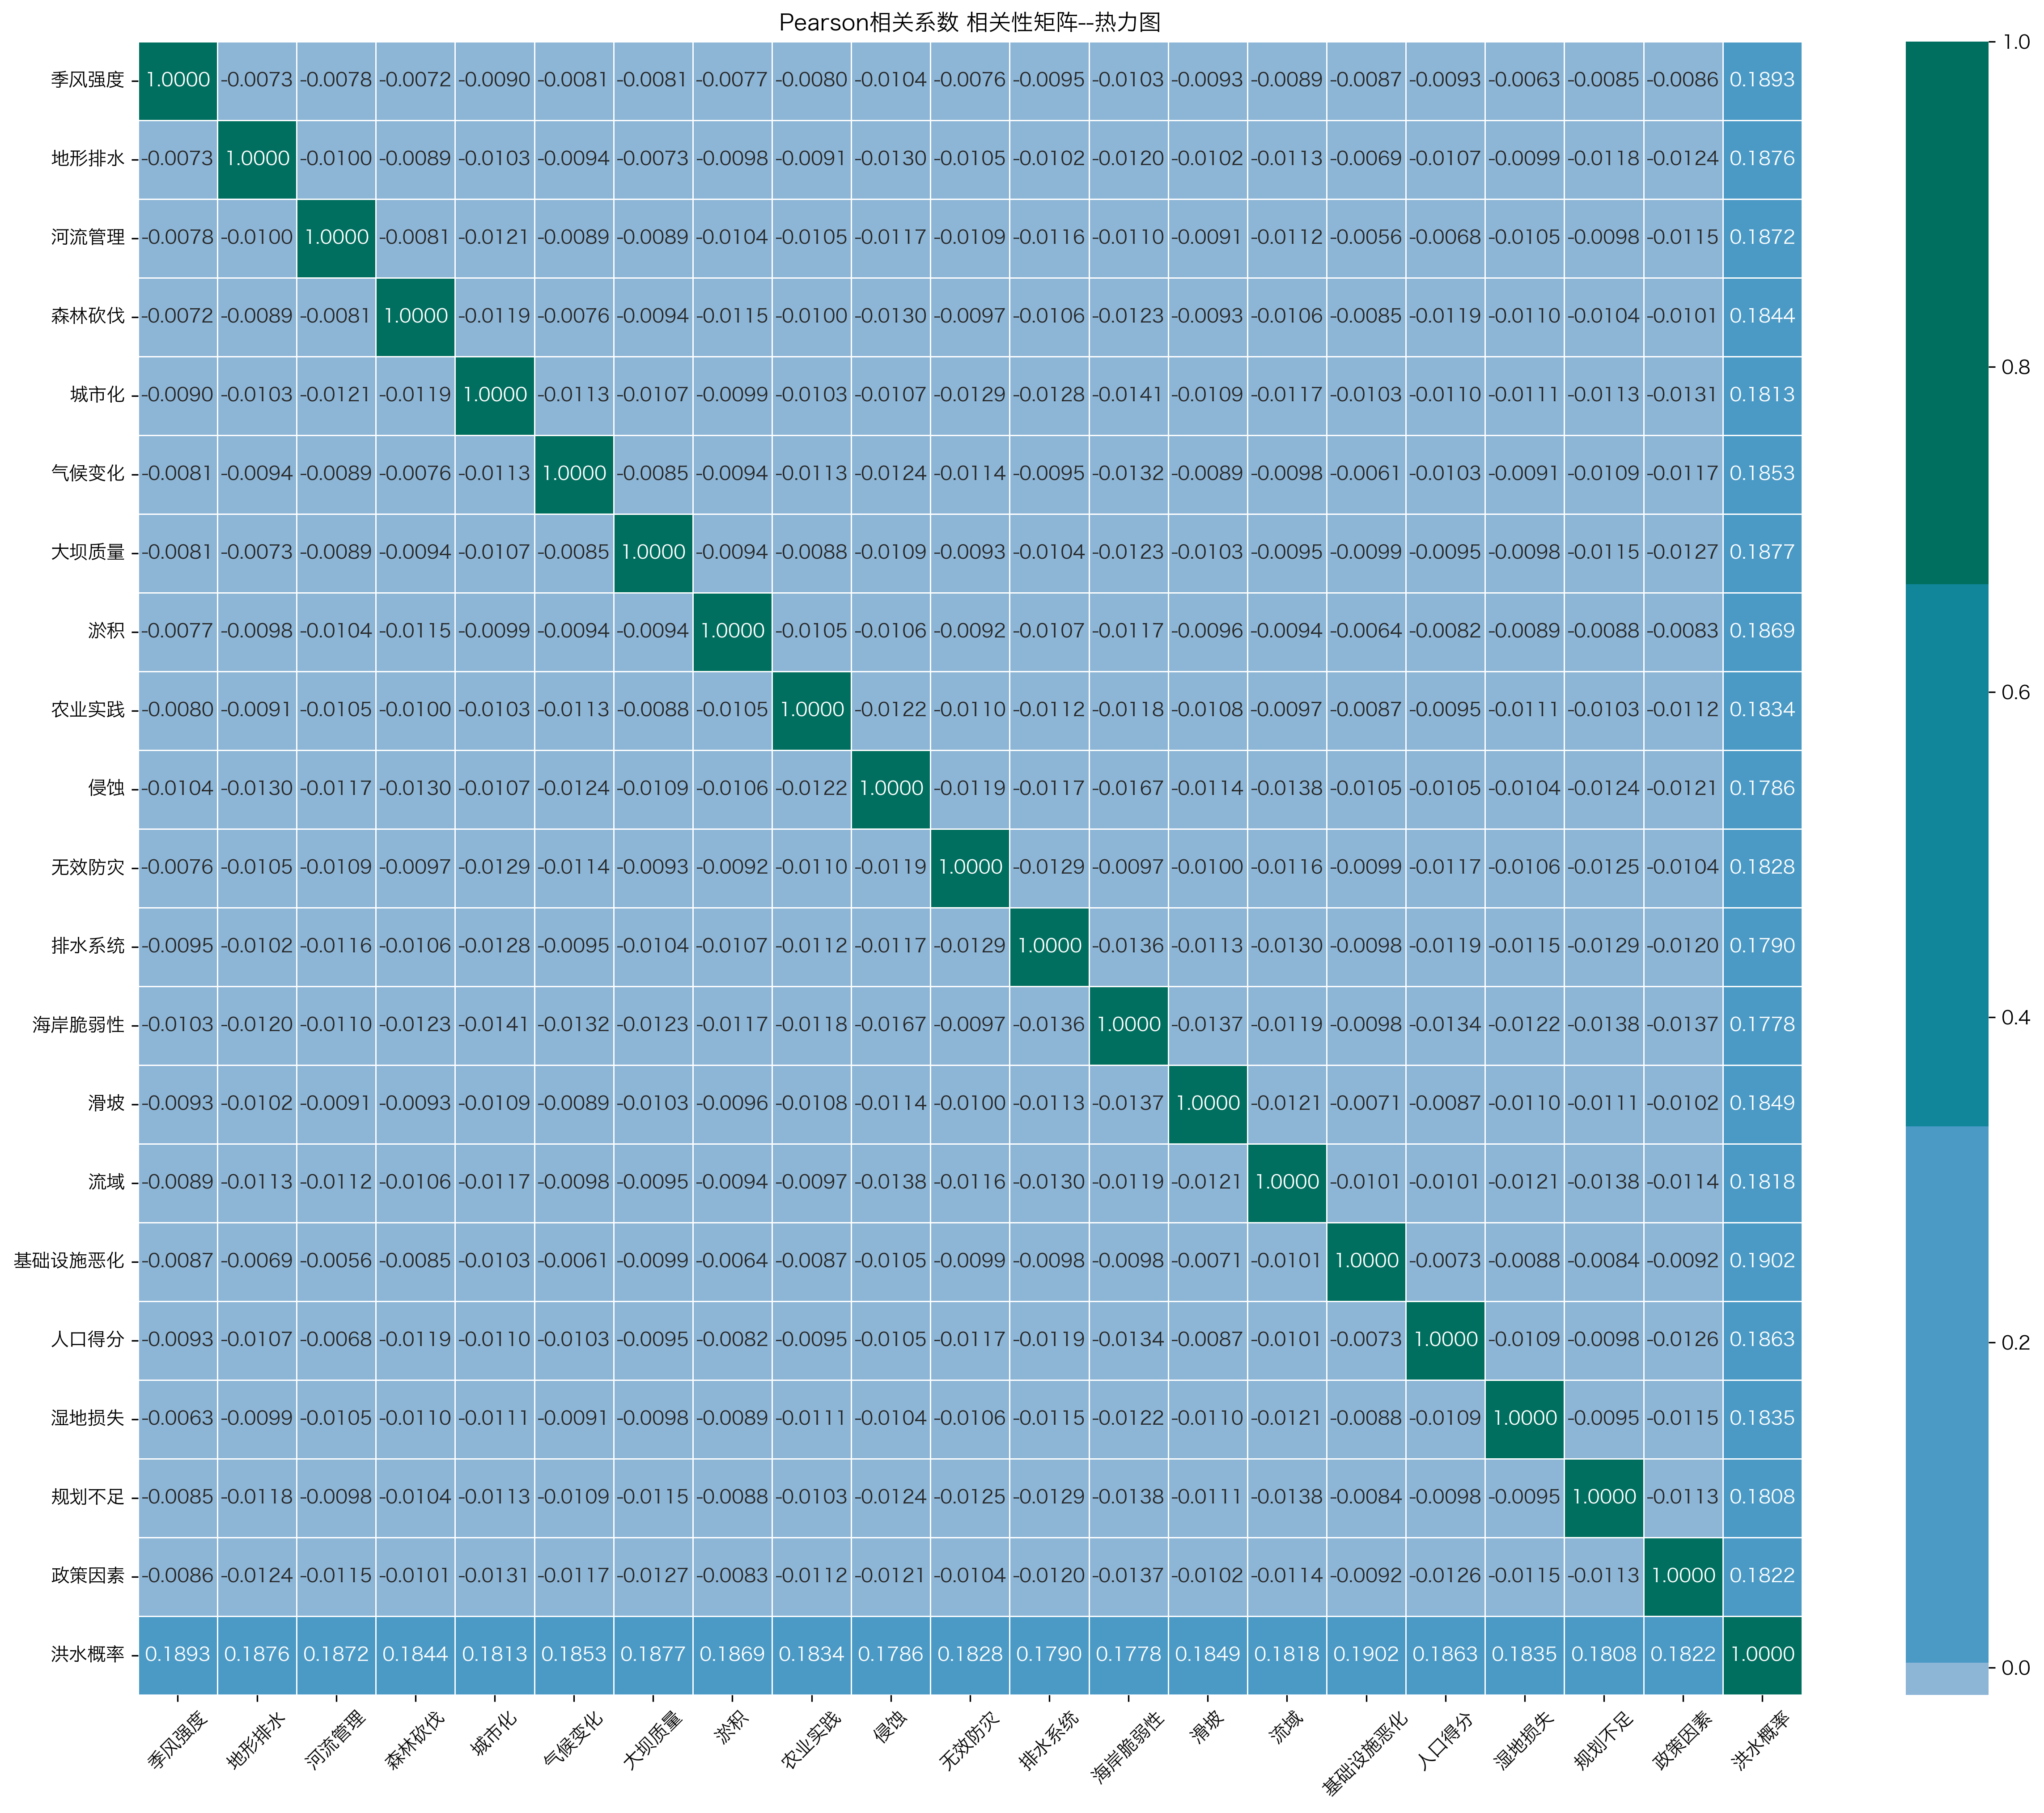

In [ ]:
corr_features = initial_features + ['洪水概率']
cc = np.corrcoef(train[corr_features], rowvar=False)
plt.figure(figsize=(20, 16), dpi=300)
sns.heatmap(cc, center=0, cmap=pal_train, annot=True, fmt='.4f',
            xticklabels=corr_features, yticklabels=corr_features,
            linewidths=0.3, linecolor='white')
plt.xticks(rotation=45)
plt.title('Pearson相关系数 相关性矩阵--热力图')
plt.show()

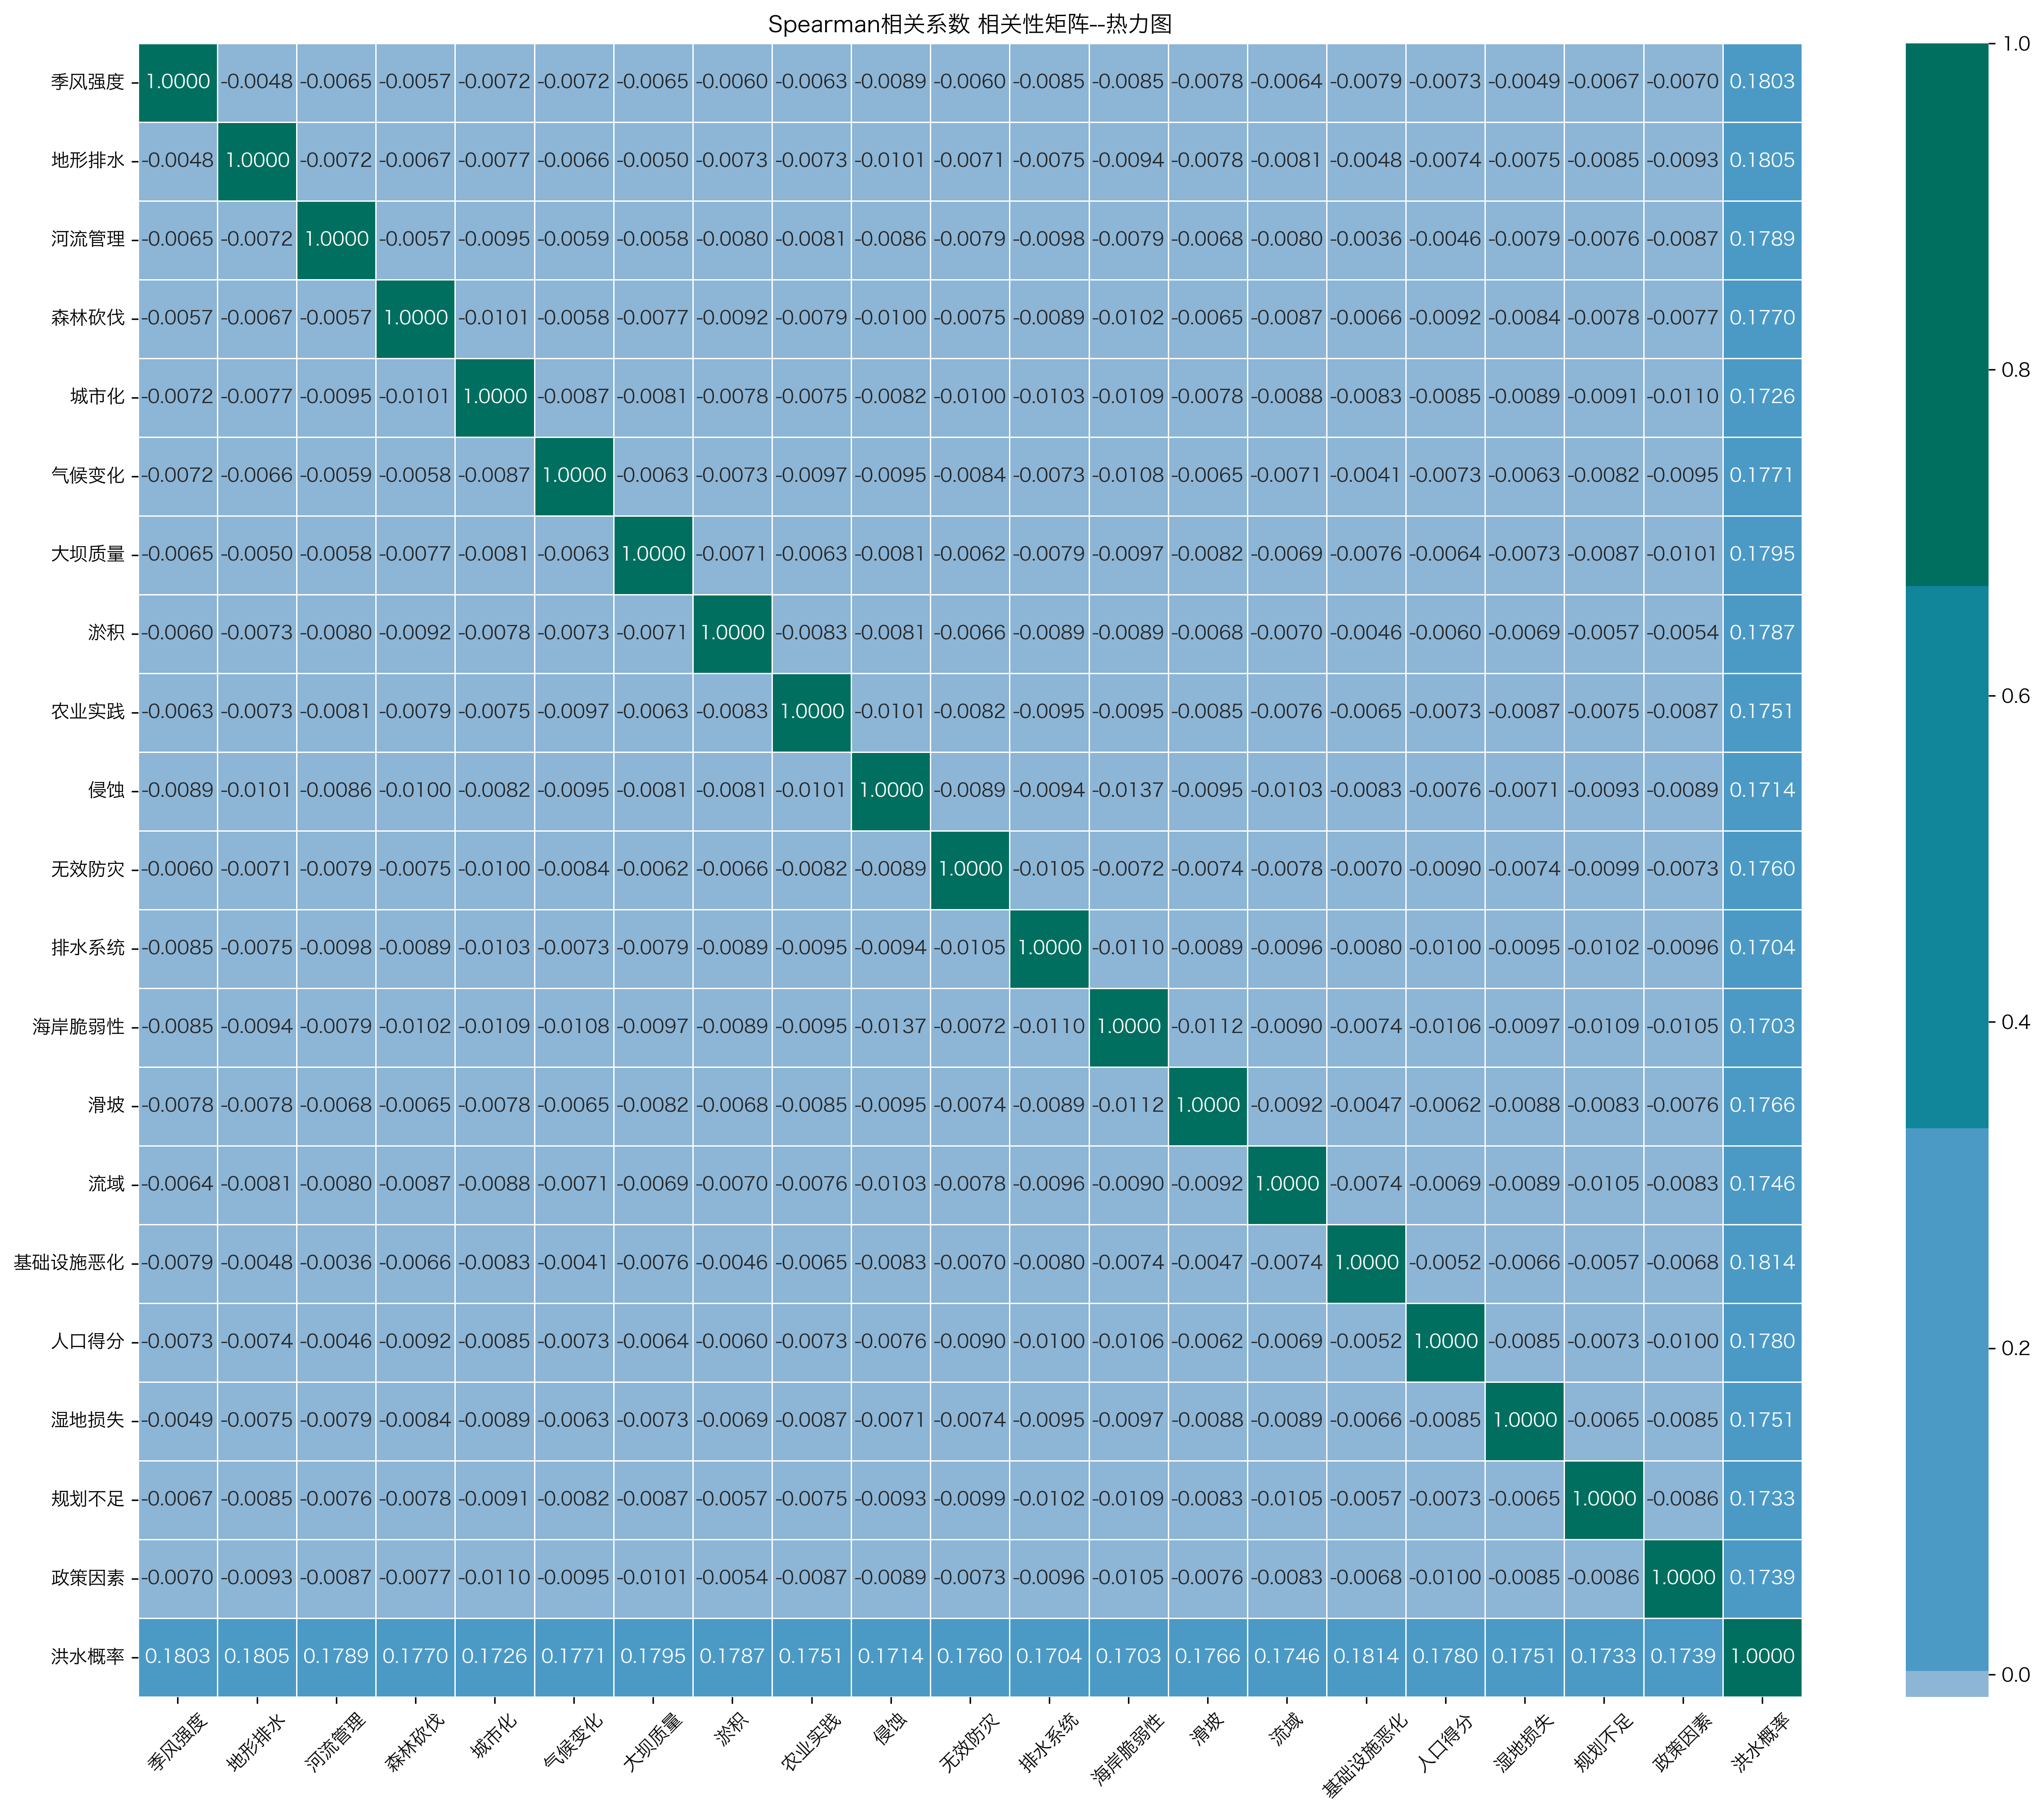

In [ ]:
spearman_corr_matrix = train[corr_features].corr(
    method='spearman', min_periods=1, numeric_only=True)

plt.figure(figsize=(20, 16), dpi=300)
sns.heatmap(spearman_corr_matrix, center=0, cmap=pal_train, annot=True, fmt='.4f',
            xticklabels=corr_features, yticklabels=corr_features,
            linewidths=0.3, linecolor='white')
plt.title('Spearman相关系数 相关性矩阵--热力图')
plt.xticks(rotation=45)
plt.show()

In [ ]:
spearman_corr_matrix

季风强度      地形排水      河流管理      森林砍伐       城市化      气候变化      大坝质量  \
季风强度    1.000000 -0.004849 -0.006462 -0.005679 -0.007153 -0.007198 -0.006472   
地形排水   -0.004849  1.000000 -0.007226 -0.006726 -0.007723 -0.006600 -0.005008   
河流管理   -0.006462 -0.007226  1.000000 -0.005711 -0.009491 -0.005934 -0.005810   
森林砍伐   -0.005679 -0.006726 -0.005711  1.000000 -0.010058 -0.005821 -0.007717   
城市化    -0.007153 -0.007723 -0.009491 -0.010058  1.000000 -0.008734 -0.008136   
气候变化   -0.007198 -0.006600 -0.005934 -0.005821 -0.008734  1.000000 -0.006317   
大坝质量   -0.006472 -0.005008 -0.005810 -0.007717 -0.008136 -0.006317  1.000000   
淤积     -0.006038 -0.007289 -0.008005 -0.009176 -0.007759 -0.007302 -0.007052   
农业实践   -0.006309 -0.007345 -0.008147 -0.007877 -0.007524 -0.009670 -0.006332   
侵蚀     -0.008862 -0.010128 -0.008632 -0.009999 -0.008231 -0.009459 -0.008055   
无效防灾   -0.006030 -0.007149 -0.007946 -0.007475 -0.009970 -0.008439 -0.006157   
排水系统   -0.008543 -0.007461 -0.009806 -0.008903 -0.010340 -0.007254 -0.007939   
海岸脆弱性  -0.008486 -0.009364 -0.007878 -0.010162 -0.010919 -0.010829 -0.009668   
滑坡     -0.007777 -0.007813 -0.006750 -0.006545 -0.007795 -0.006462 -0.008242   
流域     -0.006381 -0.008055 -0.007976 -0.008711 -0.008815 -0.007118 -0.006869   
基础设施恶化 -0.007877 -0.004760 -0.003579 -0.006648 -0.008290 -0.004141 -0.007636   
人口得分   -0.007255 -0.007426 -0.004561 -0.009180 -0.008512 -0.007279 -0.006449   
湿地损失   -0.004914 -0.007484 -0.007873 -0.008355 -0.008940 -0.006322 -0.007296   
规划不足   -0.006714 -0.008454 -0.007583 -0.007815 -0.009051 -0.008201 -0.008673   
政策因素   -0.006966 -0.009266 -0.008721 -0.007733 -0.010971 -0.009466 -0.010093   
洪水概率    0.180277  0.180483  0.178931  0.177014  0.172649  0.177119  0.179458   

              淤积      农业实践        侵蚀  ...      排水系统     海岸脆弱性        滑坡  \
季风强度   -0.006038 -0.006309 -0.008862  ... -0.008543 -0.008486 -0.007777   
地形排水   -0.007289 -0.007345 -0.010128  ... -0.007461 -0.009364 -0.007813   
河流管理   -0.008005 -0.008147 -0.008632  ... -0.009806 -0.007878 -0.006750   
森林砍伐   -0.009176 -0.007877 -0.009999  ... -0.008903 -0.010162 -0.006545   
城市化    -0.007759 -0.007524 -0.008231  ... -0.010340 -0.010919 -0.007795   
气候变化   -0.007302 -0.009670 -0.009459  ... -0.007254 -0.010829 -0.006462   
大坝质量   -0.007052 -0.006332 -0.008055  ... -0.007939 -0.009668 -0.008242   
淤积      1.000000 -0.008327 -0.008136  ... -0.008932 -0.008913 -0.006778   
农业实践   -0.008327  1.000000 -0.010106  ... -0.009493 -0.009458 -0.008461   
侵蚀     -0.008136 -0.010106  1.000000  ... -0.009384 -0.013738 -0.009482   
无效防灾   -0.006575 -0.008159 -0.008942  ... -0.010485 -0.007196 -0.007406   
排水系统   -0.008932 -0.009493 -0.009384  ...  1.000000 -0.011019 -0.008895   
海岸脆弱性  -0.008913 -0.009458 -0.013738  ... -0.011019  1.000000 -0.011249   
滑坡     -0.006778 -0.008461 -0.009482  ... -0.008895 -0.011249  1.000000   
流域     -0.006976 -0.007581 -0.010339  ... -0.009611 -0.009044 -0.009207   
基础设施恶化 -0.004575 -0.006461 -0.008342  ... -0.007968 -0.007376 -0.004731   
人口得分   -0.005988 -0.007305 -0.007579  ... -0.009951 -0.010563 -0.006163   
湿地损失   -0.006919 -0.008666 -0.007124  ... -0.009543 -0.009674 -0.008755   
规划不足   -0.005678 -0.007483 -0.009322  ... -0.010216 -0.010902 -0.008268   
政策因素   -0.005382 -0.008672 -0.008916  ... -0.009558 -0.010503 -0.007584   
洪水概率    0.178738  0.175144  0.171430  ...  0.170441  0.170289  0.176636   

              流域    基础设施恶化      人口得分      湿地损失      规划不足      政策因素      洪水概率  
季风强度   -0.006381 -0.007877 -0.007255 -0.004914 -0.006714 -0.006966  0.180277  
地形排水   -0.008055 -0.004760 -0.007426 -0.007484 -0.008454 -0.009266  0.180483  
河流管理   -0.007976 -0.003579 -0.004561 -0.007873 -0.007583 -0.008721  0.178931  
森林砍伐   -0.008711 -0.006648 -0.009180 -0.008355 -0.007815 -0.007733  0.177014  
城市化    -0.008815 -0.008290 -0.008512 -0.008940 -0.009051 -0.010971  0.172649  
气候变化   -0.007118 -0.004141 -0.007279 -0.006322 -0.008201 -0.009466  0.177119  
大坝质量   -0.006869 -0.007636 -0.006449 -0.007296 

In [ ]:
flood_corr = spearman_corr_matrix.洪水概率.drop(['洪水概率'])
flood_corr.sort_values(inplace=True, ascending=False)
flood_corr

基础设施恶化    0.181399
地形排水      0.180483
季风强度      0.180277
大坝质量      0.179458
河流管理      0.178931
淤积        0.178738
人口得分      0.177993
气候变化      0.177119
森林砍伐      0.177014
滑坡        0.176636
无效防灾      0.175972
农业实践      0.175144
湿地损失      0.175139
流域        0.174641
政策因素      0.173873
规划不足      0.173254
城市化       0.172649
侵蚀        0.171430
排水系统      0.170441
海岸脆弱性     0.170289
Name: 洪水概率, dtype: float64

**相关性分析**:
   - 已经计算了特征之间的斯皮尔曼相关系数，这将有助于识别特征间的单调关系，以及可能存在的多重共线性问题。

**多重比较校正**:
   - 进行假设检验，需要考虑使用多重比较校正方法，如Bonferroni校正，以控制第一类错误率。

In [ ]:
# 初始化一个 DataFrame 来存储 p 值
p_values = np.zeros((len(corr_features), len(corr_features)))
corrected_p_values = np.zeros((len(corr_features), len(corr_features)))

alpha = 0.005
# 对相关系数矩阵中的每个系数进行假设检验
ans_list = []
for i, row in enumerate(spearman_corr_matrix.iterrows()):
    temp = []
    for j, index in enumerate(corr_features):
        p_value = spearman_corr_matrix.loc[row[0], index]
        elem = multipletests([p_value], alpha=alpha, method='bonferroni')
        not_accept, p_corrected = elem[0], elem[1]
        if not_accept:
            corrected_p_values[i, j] = 0
        else:
            corrected_p_values[i, j] = p_corrected
        
        temp.append(elem)
    ans_list.append(temp)
    
# 展示假设检验形式
# for row in ans_list:
#     print(row)

corrected_df = pd.DataFrame(corrected_p_values, columns=corr_features, index=corr_features)
corrected_df

季风强度      地形排水      河流管理      森林砍伐       城市化      气候变化      大坝质量  \
季风强度    1.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
地形排水    0.000000  1.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
河流管理    0.000000  0.000000  1.000000  0.000000  0.000000  0.000000  0.000000   
森林砍伐    0.000000  0.000000  0.000000  1.000000  0.000000  0.000000  0.000000   
城市化     0.000000  0.000000  0.000000  0.000000  1.000000  0.000000  0.000000   
气候变化    0.000000  0.000000  0.000000  0.000000  0.000000  1.000000  0.000000   
大坝质量    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  1.000000   
淤积      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
农业实践    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
侵蚀      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
无效防灾    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
排水系统    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
海岸脆弱性   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
滑坡      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
流域      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
基础设施恶化  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
人口得分    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
湿地损失    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
规划不足    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
政策因素    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
洪水概率    0.180277  0.180483  0.178931  0.177014  0.172649  0.177119  0.179458   

              淤积      农业实践       侵蚀  ...      排水系统     海岸脆弱性        滑坡  \
季风强度    0.000000  0.000000  0.00000  ...  0.000000  0.000000  0.000000   
地形排水    0.000000  0.000000  0.00000  ...  0.000000  0.000000  0.000000   
河流管理    0.000000  0.000000  0.00000  ...  0.000000  0.000000  0.000000   
森林砍伐    0.000000  0.000000  0.00000  ...  0.000000  0.000000  0.000000   
城市化     0.000000  0.000000  0.00000  ...  0.000000  0.000000  0.000000   
气候变化    0.000000  0.000000  0.00000  ...  0.000000  0.000000  0.000000   
大坝质量    0.000000  0.000000  0.00000  ...  0.000000  0.000000  0.000000   
淤积      1.000000  0.000000  0.00000  ...  0.000000  0.000000  0.000000   
农业实践    0.000000  1.000000  0.00000  ...  0.000000  0.000000  0.000000   
侵蚀      0.000000  0.000000  1.00000  ...  0.000000  0.000000  0.000000   
无效防灾    0.000000  0.000000  0.00000  ...  0.000000  0.000000  0.000000   
排水系统    0.000000  0.000000  0.00000  ...  1.000000  0.000000  0.000000   
海岸脆弱性   0.000000  0.000000  0.00000  ...  0.000000  1.000000  0.000000   
滑坡      0.000000  0.000000  0.00000  ...  0.000000  0.000000  1.000000   
流域      0.000000  0.000000  0.00000  ...  0.000000  0.000000  0.000000   
基础设施恶化  0.000000  0.000000  0.00000  ...  0.000000  0.000000  0.000000   
人口得分    0.000000  0.000000  0.00000  ...  0.000000  0.000000  0.000000   
湿地损失    0.000000  0.000000  0.00000  ...  0.000000  0.000000  0.000000   
规划不足    0.000000  0.000000  0.00000  ...  0.000000  0.000000  0.000000   
政策因素    0.000000  0.000000  0.00000  ...  0.000000  0.000000  0.000000   
洪水概率    0.178738  0.175144  0.17143  ...  0.170441  0.170289  0.176636   

              流域    基础设施恶化      人口得分      湿地损失      规划不足      政策因素      洪水概率  
季风强度    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.180277  
地形排水    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.180483  
河流管理    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.178931  
森林砍伐    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.177014  
城市化     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.172649  
气候变化    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.177119  
大坝质量    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0

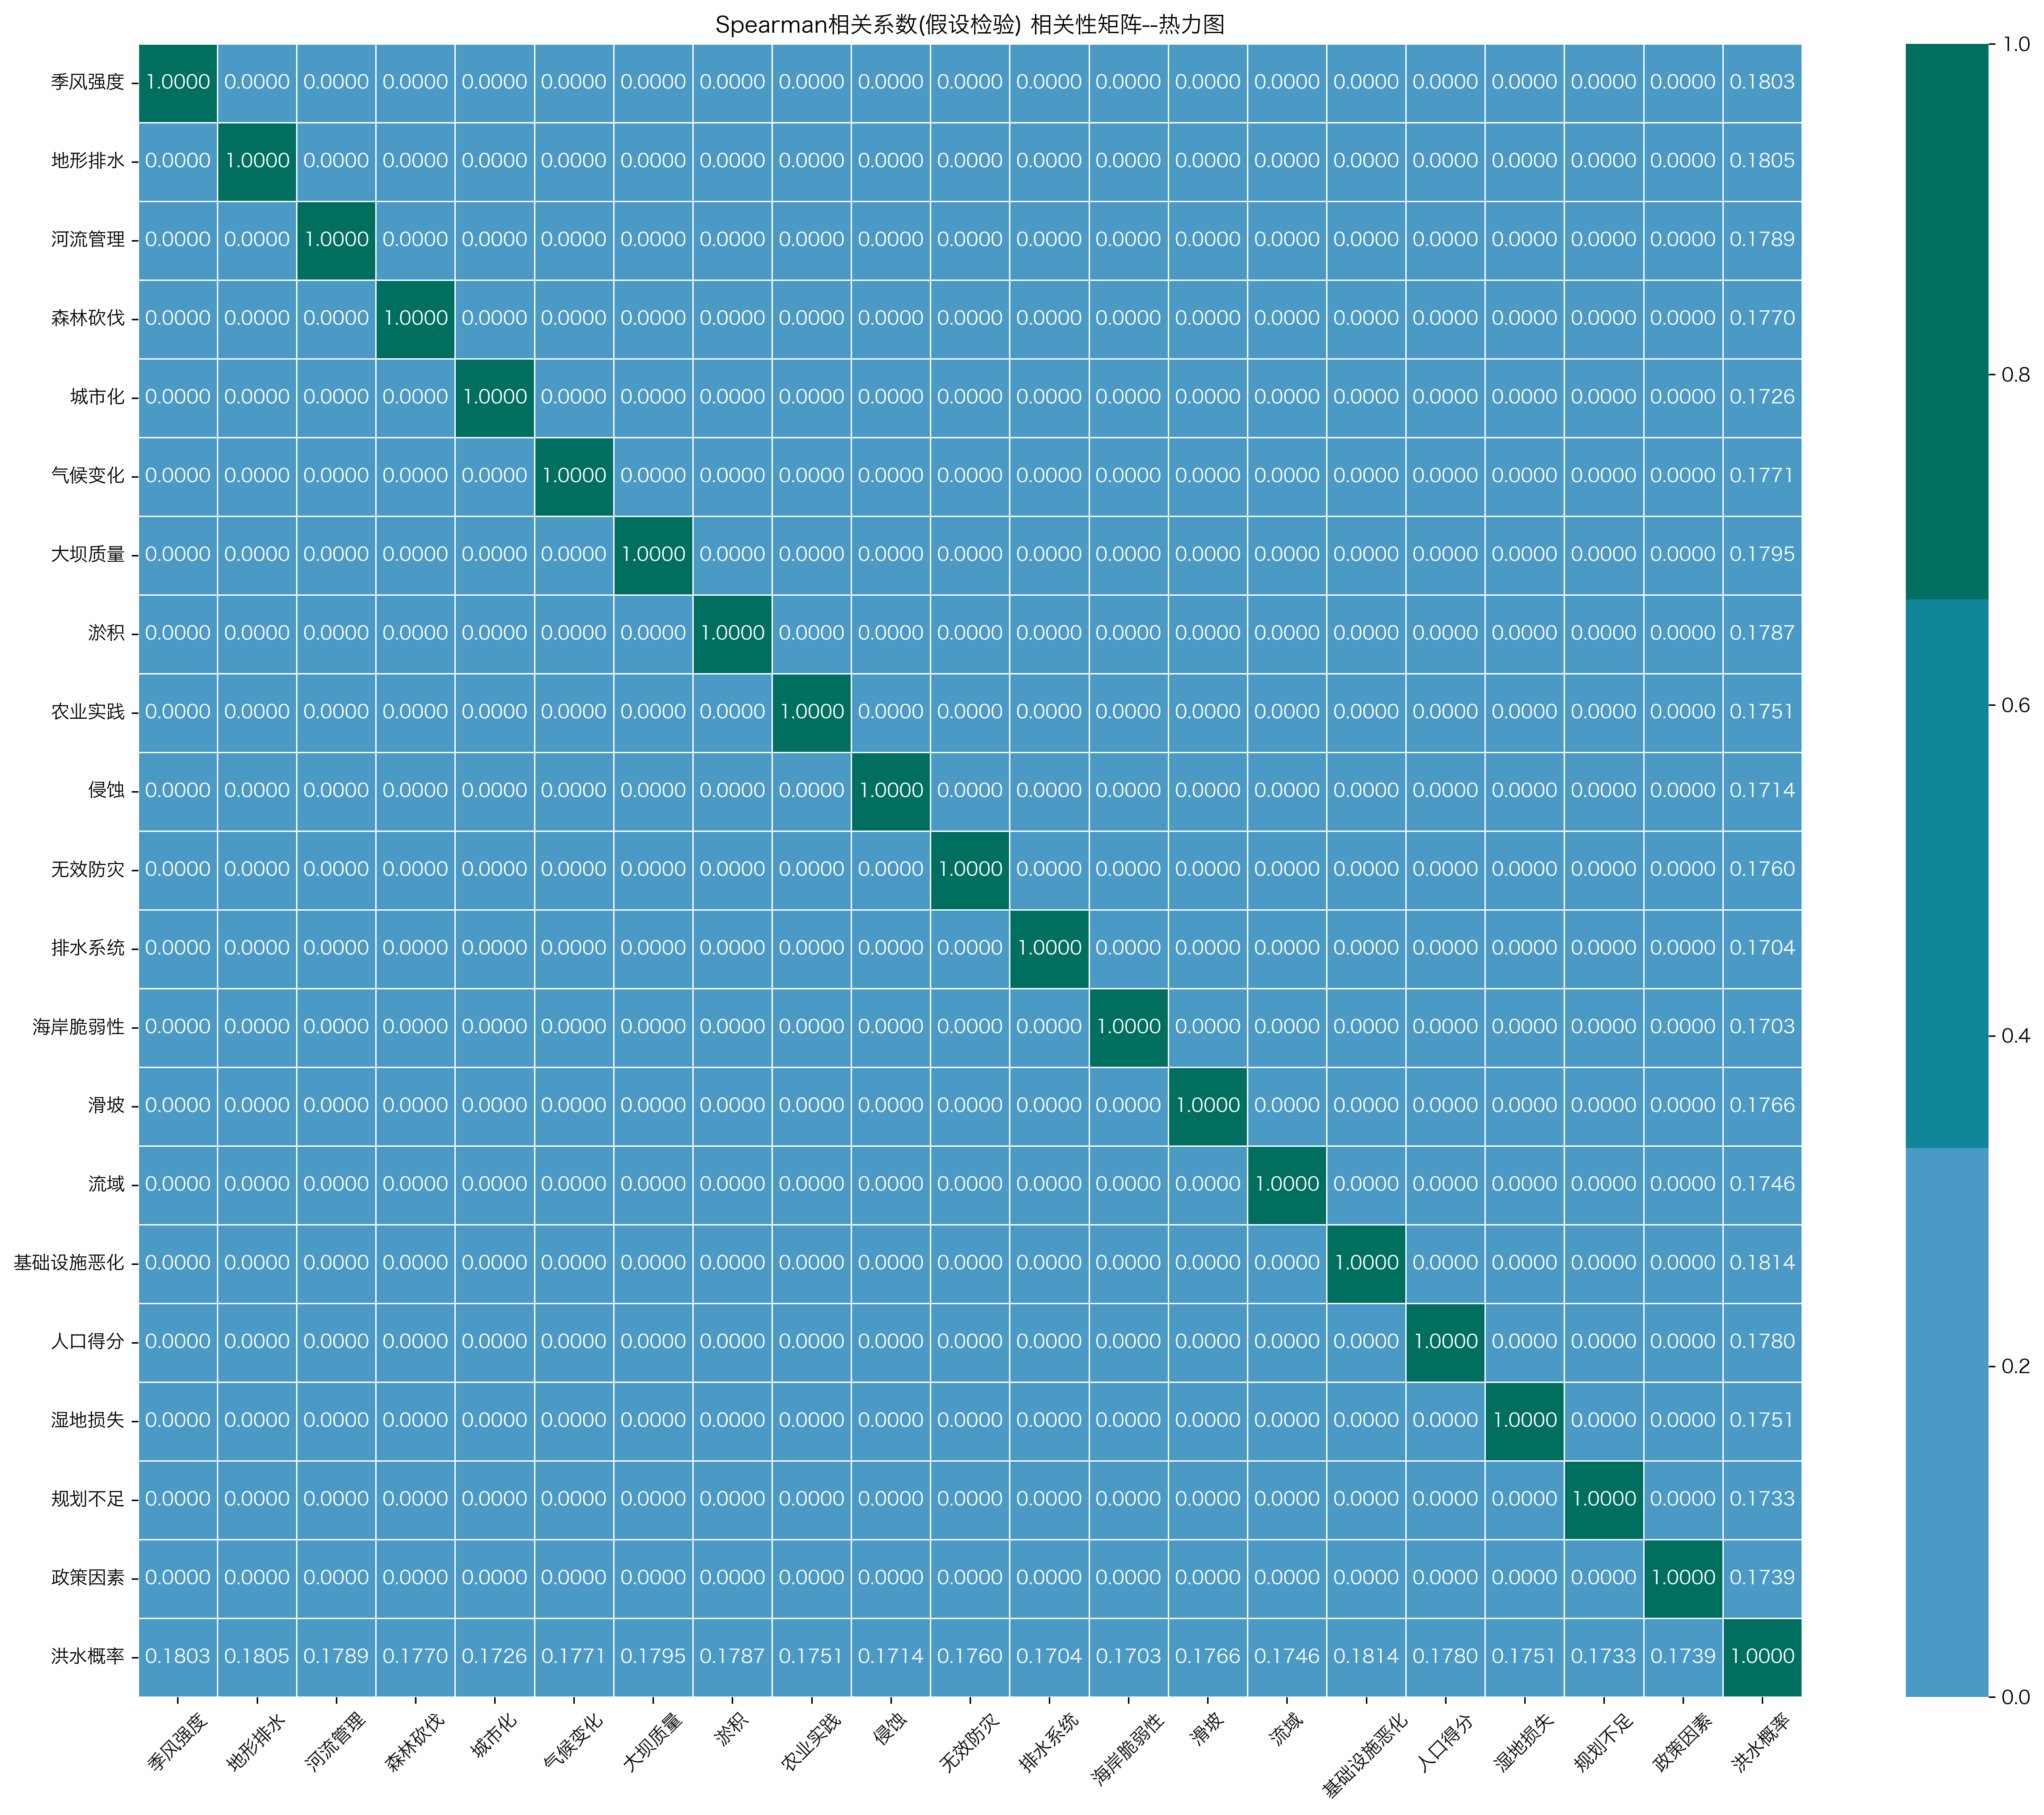

In [ ]:
plt.figure(figsize=(20, 16), dpi=300)
sns.heatmap(corrected_df, center=0, cmap=pal_train, annot=True, fmt='.4f',
            xticklabels=corr_features, yticklabels=corr_features,
            linewidths=0.3, linecolor='white')
plt.title('Spearman相关系数(假设检验) 相关性矩阵--热力图')
plt.xticks(rotation=45)
plt.show()